In [1]:
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import cupy as cp
from cupy.fft import fft

In [3]:
import numpy as np
import pandas as pd
#from scipy.fftpack import fft
from scipy.optimize import minimize
import time


In [4]:
def precompute_values_gpu(betX, bn=2**7):
    
    m = len(betX)
    bX = betX.reshape(1, m)
    minX = cp.mean(bX) - (5 * cp.std(bX))
    maxX = cp.mean(bX) + (5 * cp.std(bX))
    dX = (maxX - minX) / (bn - 1)
    minX = minX - dX/2
    maxX = maxX + dX/2
    bXi = cp.ceil((bX - minX) / dX).astype(int) 
    bXi[bXi < 1] = 1
    bXi[bXi > bn] = bn
    j = cp.arange(bn)
    vi = 2 * cp.pi * (j - bn/2) / (maxX - minX - dX)
    Rx = vi
    Rx_sq_half = -0.5 * Rx**2
    mf_init = -2 * cp.log(cp.complex128(-1)) * ((minX + dX/2) / (maxX - minX - dX)) * j
    mf = mf_init
    FFTmod_init = (1 / (maxX - minX - dX)) * (cp.complex128(-1))**(bn * ((minX + dX/2) / (maxX - minX - dX)) + j)
    FFTmod = FFTmod_init
    flat_bXi = bXi.flatten() - 1

    # Note: if you need to return the arrays back to CPU memory, use cp.asnumpy(...)
    return m, Rx, Rx_sq_half, mf, FFTmod, flat_bXi

In [5]:
def precompute_values(betX, bn=2**7):
    m = len(betX)
    bX = np.array(betX).reshape(1, m)
    minX = np.mean(bX) - (5 * np.std(bX))
    maxX = np.mean(bX) + (5 * np.std(bX))
    dX = (maxX - minX) / (bn - 1)
    minX = minX - dX/2
    maxX = maxX + dX/2
    bXi = np.ceil((bX - minX) / dX).astype(int) 
    bXi[bXi < 1] = 1
    bXi[bXi > bn] = bn
    j = np.arange(bn)
    vi = 2 * np.pi * (j - bn/2) / (maxX - minX - dX)
    Rx = np.array(vi)
    Rx_sq_half = -0.5 * Rx**2
    mf_init = -2 * np.log(np.complex128(-1)) * ((minX + dX/2) / (maxX - minX - dX)) * j
    mf = np.array(mf_init)
    FFTmod_init = (1 / (maxX - minX - dX)) * (np.complex128(-1))**(bn * ((minX + dX/2) / (maxX - minX - dX)) + j)
    FFTmod = np.array(FFTmod_init)
    flat_bXi = bXi.flatten() - 1

    # Return the precomputed values
    return m, Rx, Rx_sq_half, mf, FFTmod, flat_bXi

def singleTrait_likelihood(theta, betX, w8s, nX, m, Rx, Rx_sq_half, mf, FFTmod, flat_bXi, bn=2**7):
    # Transfer arrays to GPU memory
    theta = cp.array(theta)
    #betX = cp.array(betX)
    #w8s = cp.array(w8s)
    #Rx = cp.array(Rx)
    #Rx_sq_half = cp.array(Rx_sq_half)
    #mf = cp.array(mf)
    #FFTmod = cp.array(FFTmod)
    #flat_bXi = cp.array(flat_bXi)

    piX = cp.abs(theta[0])
    h2X = cp.abs(theta[1])
    iX = cp.abs(theta[2])
    
    sigX_sq = h2X / (piX * m)
    Rp = iX / nX

    Ax_sq = cp.repeat(sigX_sq, bn)
    Qx = cp.repeat(piX, bn)
    Lx = - (1 - cp.exp(Ax_sq * Rx_sq_half)) * Qx
    Le = (Rp * Rx_sq_half)

    phi = cp.exp(Lx + Le + mf)
    FFT = fft(phi)
    FFT0 = cp.real(FFT * FFTmod)

    pfE = FFT0[flat_bXi]
    my_w8s = w8s[pfE > 0]
    pfE = pfE[pfE > 0]

    logL = -m * cp.mean(cp.log(pfE * my_w8s))
    
    return logL.item()



In [6]:

def precompute_values_twoStep_gpu(betXY, piX, piU, piY, nX, nY, bn=2**8):
    
    m = betXY.shape[0]

    bX = betXY[:, 0].reshape(1, 1, m)
    bY = betXY[:, 1].reshape(1, 1, m)

    minX = cp.mean(bX) - (5 * cp.std(bX))
    maxX = cp.mean(bX) + (5 * cp.std(bX))
    minY = cp.mean(bY) - (5 * cp.std(bY))
    maxY = cp.mean(bY) + (5 * cp.std(bY))

    dX = (maxX - minX) / (bn - 1)
    dY = (maxY - minY) / (bn - 1)
    minX = minX - dX/2
    maxX = maxX + dX/2
    minY = minY - dY/2
    maxY = maxY + dY/2

    bXi = cp.ceil((bX - minX) / dX).astype(int)
    bYi = cp.ceil((bY - minY) / dY).astype(int)
    bXi[bXi < 1] = 1
    bXi[bXi > bn] = bn
    bYi[bYi < 1] = 1
    bYi[bYi > bn] = bn

    j = cp.arange(bn)
    vi = 2 * cp.pi * (j - bn/2) / (maxX - minX - dX)
    wj = 2 * cp.pi * (j - bn/2) / (maxY - minY - dY)
    Rx = cp.tile(vi, (bn, 1))
    Ry = cp.tile(wj, (bn, 1)).T

    Rx_sq = Rx**2
    Ry_sq = Ry**2
    Rx_Ry = Rx*Ry
    
    mf_init = -2 * cp.log(cp.complex128(-1)) * (cp.tile(((minX + dX/2) / (maxX - minX - dX)) * j, (bn, 1)) + cp.tile(((minY + dY/2) / (maxY - minY - dX)) * j.reshape(-1, 1), (1, bn)))
    mf = mf_init

    j_col = j[:, cp.newaxis]
    j_row = j[cp.newaxis, :]

    FFTmod_init = (1 / ((maxX - minX - dX) * (maxY - minY - dY))) * (cp.complex128(-1))**(bn * ((minX + dX/2) / (maxX - minX - dX) + (minY + dY/2) / (maxY - minY - dY)) + (j_col + j_row))
    FFTmod = FFTmod_init.reshape(bn, bn)

    ixF = cp.column_stack((bXi[0, 0, :] - 1, bYi[0, 0, :] - 1))  # -1 for 0-based indexing

    return m, Rx, Ry, mf, FFTmod, ixF, Rx_sq, Ry_sq, Rx_Ry


In [7]:
def precompute_values_twoStep(betXY, piX, piU, piY, nX, nY, bn=2**8):
    m = betXY.shape[0]
    bn = m

    bX = betXY[:, 0].reshape(1, 1, m)
    bY = betXY[:, 1].reshape(1, 1, m)

    minX = np.mean(bX) - (5 * np.std(bX))
    maxX = np.mean(bX) + (5 * np.std(bX))
    minY = np.mean(bY) - (5 * np.std(bY))
    maxY = np.mean(bY) + (5 * np.std(bY))

    dX = (maxX - minX) / (bn - 1)
    dY = (maxY - minY) / (bn - 1)
    minX = minX - dX/2
    maxX = maxX + dX/2
    minY = minY - dY/2
    maxY = maxY + dY/2

    bXi = np.ceil((bX - minX) / dX).astype(int)
    bYi = np.ceil((bY - minY) / dY).astype(int)
    bXi[bXi < 1] = 1
    bXi[bXi > bn] = bn
    bYi[bYi < 1] = 1
    bYi[bYi > bn] = bn

    j = np.arange(bn)
    vi = 2 * np.pi * (j - bn/2) / (maxX - minX - dX)
    wj = 2 * np.pi * (j - bn/2) / (maxY - minY - dY)
    Rx = np.tile(vi, (bn, 1))
    Ry = np.tile(wj, (bn, 1)).T

    Rx_sq = Rx**2
    Ry_sq = Ry**2
    Rx_Ry = Rx*Ry
    
    mf_init = -2 * np.log(np.complex128(-1)) * (np.tile(((minX + dX/2) / (maxX - minX - dX)) * j, (bn, 1)) + np.tile(((minY + dY/2) / (maxY - minY - dX)) * j.reshape(-1, 1), (1, bn)))
    mf = np.array(mf_init)

    FFTmod_init = (1 / ((maxX - minX - dX) * (maxY - minY - dY))) * (np.complex128(-1))**(bn * ((minX + dX/2) / (maxX - minX - dX) + (minY + dY/2) / (maxY - minY - dY)) + np.add.outer(j, j))
    FFTmod = FFTmod_init.reshape(bn, bn)

    ixF = np.column_stack((bXi[0, 0, :] - 1, bYi[0, 0, :] - 1))  # -1 for 0-based indexing

    return m,  Rx, Ry, mf, FFTmod, ixF, Rx_sq, Ry_sq, Rx_Ry

def pairTrait_twoStep_likelihood_old(theta, betXY, w8s, precomputed_values, model="comp"):
    # Unpack precomputed values
    m,  Rx, Ry,  mf, FFTmod, ixF, Rx_sq, Ry_sq, Rx_Ry = precomputed_values
    
    # Extract parameters from theta
    h2X = np.abs(theta[0])
    h2Y = np.abs(theta[1])

    if model == "X1":
        tX = np.abs(theta[2])
        tY = theta[3]
        axy = theta[4]
        ayx = 0
        iXY = theta[6]
    elif model == "X2":
        tX = np.abs(theta[2])
        tY = theta[3]
        axy = 0
        ayx = theta[5]
        iXY = theta[6]
    elif model == "X3":
        tX = np.abs(theta[2])
        tY = theta[3]
        axy = 0
        ayx = 0
        iXY = theta[6]

    sigX_sq = h2X/(piX*m)
    sigU_sq = 1/(piU*m)
    sigY_sq = h2Y/(piY*m)
    
    Rp = np.array([[iX/nX, iXY/np.sqrt(nX*nY)], [iXY/np.sqrt(nX*nY), iY/nY]])

    # Compute coX, coY, coU, Lx, and Ly
    coX = Rx + axy * Ry
    coY = Ry + ayx * Rx
    coU = sigU_sq * ((tX + ayx * tY) * Rx + (tY + axy * tX) * Ry)

    Lx = - m * (1 - np.exp(-0.5 * sigX_sq * coX**2))
    Ly = - m * (1 - np.exp(-0.5 * sigY_sq * coY**2))
    Le = -0.5 * ((Rp[0, 0] * Rx_sq + Rp[1, 1] * Ry_sq) + 2 * Rp[0, 1] * (Rx_Ry))

    # Calculate phi, FFT, FFT0
    phi = np.exp(Lx + Ly + Le + mf)
    FFT = fft(phi, axis=0)
    FFT0 = np.real(FFT * FFTmod)

    # Extract probability densities for observed effect sizes
    pfE = FFT0[ixF[:, 0], ixF[:, 1]]
    selu = np.where(pfE > 0)[0]
    pfE = pfE[selu]
    my_w8s = w8s[selu]

    # Calculate log-likelihood
    logL = -np.mean(np.log(pfE * my_w8s))

    return logL

In [8]:
def pairTrait_twoStep_likelihood(theta, betXY, w8s, precomputed_values, model="comp"):
    # Transfer arrays to GPU memory
    theta = cp.array(theta)
    #betXY = cp.array(betXY)
    #w8s = cp.array(w8s)
    #precomputed_values = [cp.array(value) for value in precomputed_values]

    # Unpack precomputed values
    m, Rx, Ry, mf, FFTmod, ixF, Rx_sq, Ry_sq, Rx_Ry = precomputed_values
    
    # Extract parameters from theta
    h2X = cp.abs(theta[0])
    h2Y = cp.abs(theta[1])

    if model == "X1":
        tX = cp.abs(theta[2])
        tY = theta[3]
        axy = theta[4]
        ayx = 0
        iXY = theta[6]
    elif model == "X2":
        tX = cp.abs(theta[2])
        tY = theta[3]
        axy = 0
        ayx = theta[5]
        iXY = theta[6]
    elif model == "X3":
        tX = cp.abs(theta[2])
        tY = theta[3]
        axy = 0
        ayx = 0
        iXY = theta[6]

    sigX_sq = h2X/(piX*m)
    sigU_sq = 1/(piU*m)
    sigY_sq = h2Y/(piY*m)
    
    Rp = cp.array([[cp.abs(iX/nX), iXY/cp.sqrt(nX*nY)], [iXY/cp.sqrt(nX*nY), cp.abs(iY/nY)]])

    # Compute coX, coY, coU, Lx, and Ly
    coX = Rx + axy * Ry
    coY = Ry + ayx * Rx
    coU = sigU_sq * ((tX + ayx * tY) * Rx + (tY + axy * tX) * Ry)

    Lx = - m * (1 - cp.exp(-0.5 * sigX_sq * coX**2))
    Ly = - m * (1 - cp.exp(-0.5 * sigY_sq * coY**2))
    Le = -0.5 * ((Rp[0, 0] * Rx_sq + Rp[1, 1] * Ry_sq) + 2 * Rp[0, 1] * (Rx_Ry))
    Lu = -m * piU * (1 - cp.exp(-0.5 * coU**2))
    # Calculate phi, FFT, FFT0
    phi = cp.exp(Lx + Ly + Le + mf)
    FFT = fft(phi, axis=0)
    FFT0 = cp.real(FFT * FFTmod)

    # Extract probability densities for observed effect sizes
    pfE = FFT0[ixF[:, 0], ixF[:, 1]]
    selu = cp.where(pfE > 0)[0]
    pfE = pfE[selu]
    my_w8s = w8s[selu]

    # Calculate log-likelihood
    logL = -cp.mean(cp.log(pfE * my_w8s))

    return logL.item()

In [9]:

# sanity check mememememmememememmemememeeeeeeemee

n = 50000  # Sample size (number of individuals)
p = 100  # Number of SNPs
num_X1 = num_X2 = num_X3 = 0 # Number of genes
num_X1=1
nX=nY=n
def sim_hr(p, pi, sig):
    hX = cp.random.binomial(1, pi, p).astype(cp.float32)
    seli = cp.where(hX == 1.0)
    tmp = cp.random.normal(0, sig, len(seli[0]))
    hX[seli] = tmp
    return hX

piX = 0.05  # Proportion for X.
h2X = .3 # Direct heritability of X's
piY = 0.1  # Proportion for Y.
h2Y = .2 # Direct heritability of Y

qY = .1 # Y variance explained by confounder
q1 = q2 = q3 = 0.2 # X variance explained by confounder
sigX = cp.sqrt(h2X / (p * piX))
sigY = cp.sqrt(h2Y / (p * piY))

alp1 = 0.1
alp2 = 0.25

piU = 0.1  # Proportion for U.
# h2U = 0 # Direct heritability of U
# sigU = 0

# 1. Simulate the SNP matrix G
q = cp.random.uniform(0.05, 0.5, p)
G = cp.array([(cp.random.binomial(2, qq, size=n) - 2 * qq) / cp.sqrt(2 * qq * (1 - qq)) for qq in q]).T

# 2. Simulate U (unobserved confounder)
U = cp.random.normal(0, 1, n)

iX = 1;
iY = 1;
iXY = 0;

tX=0
tY=0

# 3. Simulate gene expressions X
# X1
gamma_1_list = [sim_hr(p, piX, sigX) for _ in range(num_X1)]
e_1_list = [cp.random.normal(0, cp.sqrt(1 - h2X - q1**2), n) for _ in range(num_X1)]
X1 = cp.array([(q1*U + G @ gamma_1_list[idx] + e_1_list[idx]) for idx in range(num_X1)]).T
# X3
gamma_3_list = [sim_hr(p, piX, sigX) for _ in range(num_X3)]
e_3_list = [cp.random.normal(0, cp.sqrt(1 - h2X - q3**2), n) for _ in range(num_X3)]
X3 = cp.array([(q3*U + G @ gamma_3_list[idx] + e_3_list[idx]) for idx in range(num_X3)]).T
# Y
gamma_y = sim_hr(p, piY, sigY)
e_y = cp.random.normal(0, cp.sqrt(1 - h2Y - qY**2 - 2 * num_X1 * (qY * alp1 * q1) - num_X1 * (1 + (num_X1-1)*q1**2) * alp1**2), n)
Y = qY*U + cp.sum(alp1*X1, axis=1) + G @ gamma_y + e_y
# X2
gamma_2_list = [sim_hr(p, piX, sigX) for _ in range(num_X2)]
e_2_list = [cp.random.normal(0, cp.sqrt(1 - h2X - q2**2 - alp2**2 - 2 * qY * alp2 * q2 \
    - 2 * num_X1 * alp1 * alp2 * q1 * (q2 + alp2 * qY) - num_X1 * (num_X1-1) * q1**2 * alp1**2 * alp2**2), n) for _ in range(num_X2)]
X2 = cp.array([(q2 * U + alp2 * Y + G @ gamma_2_list[idx] + e_2_list[idx]) for idx in range(num_X2)]).T

# To print the variances, we need to transfer the data back to the host (CPU)
# and convert it back to NumPy arrays
print(cp.asnumpy(cp.var(X1, axis=0)))
print(cp.asnumpy(cp.var(X2, axis=0)))
print(cp.asnumpy(cp.var(X3, axis=0)))
print(cp.asnumpy(cp.var(Y)))


[0.76200165]
nan
nan
1.0893729900540994


In [10]:
def simple_linregress(x, y):
    # Assuming x and y are both cupy arrays and x is a single feature.
    # x needs to be reshaped to a column vector if it's a 1D array.
    if x.ndim == 1:
        x = x[:, cp.newaxis]
        
    # Adding a column of ones to x to represent the intercept coefficients.
    X = cp.concatenate([cp.ones((x.shape[0], 1), dtype=x.dtype), x], axis=1)
    
    # Calculating the coefficients using the least squares method.
    # We use the formula (X^T * X)^(-1) * X^T * y
    coeffs = cp.linalg.inv(X.T @ X) @ X.T @ y
    
    # The slope is the second coefficient, and the intercept is the first.
    slope = coeffs[1]
    intercept = coeffs[0]
    
    # We don't calculate r_value, p_value, std_err for simplicity.
    # If you need these, additional calculations are required.
    return slope, intercept

# Now we will use this function to replace linregress in your loops:
beta_Y = cp.array([simple_linregress(G[:, j], Y.ravel())[0] for j in range(p)])

beta_X1 = cp.stack([
    cp.array([simple_linregress(G[:, j], X1[:, i])[0] for j in range(p)])
    for i in range(num_X1)
])

#beta_X2 = cp.stack([
#    cp.array([simple_linregress(G[:, j], X2[:, i])[0] for j in range(p)])
#    for i in range(num_X2)
#])

#beta_X3 = cp.stack([
#    cp.array([simple_linregress(G[:, j], X3[:, i])[0] for j in range(p)])
#    for i in range(num_X3)
#])

In [11]:
def singleTrait_function(betX, nX, par_df):
    mLL = []
    par = []
    conv = []
    betX_cp = cp.array(betX)
    precomputed_data = precompute_values_gpu(betX_cp)
    w8s = cp.repeat(cp.abs(1),p)
    
    for idx in range(par_df.shape[0]):
        x = par_df.iloc[idx].to_list()
        # Define objective function for optimization
        def objective(theta):
            return singleTrait_likelihood(theta, betX, w8s, nX, *precomputed_data, bn=2**7)
        # Run optimization
        res = minimize(objective, x, method='Nelder-Mead', options={'maxiter': 5000})
        # Collect results
        mLL.append(res.fun)
        par.append(res.x)
        conv.append(res.success)
    return mLL, np.array(par), conv
# singleTrait_likelihood(theta, betX, w8s, nX, bn=2**7, bins=10)
def pairTrait_function(betXY, nX, nY, par_df, model):
    mLL = []
    par = []
    conv = []
    betXY = cp.array(betXY)

    precomputed_values = precompute_values_twoStep_gpu(betXY, piX, piU, piY, nX, nY)
    w8s = cp.repeat(cp.abs(1),p)

    for idx in range(par_df.shape[0]):
        x = par_df.iloc[idx].to_list()
        def objective(theta):
            return pairTrait_twoStep_likelihood(theta, betXY, w8s, precomputed_values, model=model)
        res = minimize(objective, x, method='Nelder-Mead', options={'maxiter': 5000})
        mLL.append(res.fun)
        par.append(res.x)
        conv.append(res.success)
    return mLL, np.array(par), conv
    
# pairTrait_twoStep_likelihood(theta, betXY, w8s, pi_U=0.1, pi_X=None, pi_Y=None, i_X=None, i_Y=None, nX=None, nY=None, model="comp", bn=2**8, bins=15)
# test = optim(theta, lhcMR:::pairTrait_twoStep_likelihood,
#         betX=betXY, pi1=pi1, sig1=sig1, w8s=w8s, M=M,
#         m0=m0, nX=nX, nY=nY, pi_U=piU, pi_X=piX, pi_Y=piY, i_X=iX, i_Y=iY,
#         bn=2^7, bins=10,
#         method = "Nelder-Mead",
#         control = list(maxit = 5e3,
#                         parscale = parscale2))

In [12]:
def singleTrait_function_plot(betX, nX, par_df):
    # Extract only the first row of par_df
    fixed_params = par_df.iloc[0, 2:].to_list()  # Get the rest of the parameters after the first two
    mLL = []
    param_1_values = np.linspace(0.001, 1, 20)
    param_2_values = np.linspace(0.001, 1, 20)
    betX_cp = cp.array(betX)
    precomputed_data = precompute_values_gpu(betX_cp)
    w8s = cp.repeat(cp.abs(1), p)
    
    # Calculate likelihood for each combination of first two parameters
    for param_1 in param_1_values:
        for param_2 in param_2_values:
            params = [param_1, param_2] + fixed_params
            likelihood = singleTrait_likelihood(params, betX, w8s, nX, *precomputed_data, bn=2**7)
            mLL.append(likelihood)
    
    # Reshape mLL to a 20x20 grid to match param_1_values and param_2_values
    mLL_grid = np.reshape(mLL, (20, 20))

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a meshgrid for the parameters to plot the surface
    param_1_mesh, param_2_mesh = np.meshgrid(param_1_values, param_2_values)

    # Plot the surface
    ax.plot_surface(param_1_mesh, param_2_mesh, mLL_grid, cmap='viridis')

    # Set labels
    ax.set_xlabel('Parameter 1')
    ax.set_ylabel('Parameter 2')
    ax.set_zlabel('-Log Likelihood')

    # Show plot
    plt.show()

    return mLL_grid, param_1_values, param_2_values


def pairTrait_function_plot(betXY, nX, nY, par_df, model):
    # Assume piX, piU, piY have been defined elsewhere in your code
    mLL_grid = np.zeros((20, 20))  # Create a grid for the likelihood values
    param_1_values = np.linspace(0.001, 1, 20)
    param_2_values = np.linspace(0.001, 1, 20)
    betXY_cp = cp.array(betXY)
    precomputed_values = precompute_values_twoStep_gpu(betXY_cp, piX, piU, piY, nX, nY)
    w8s = cp.repeat(cp.abs(1), p)

    # Only use the first row of par_df for the fixed parameters
    fixed_params = par_df.iloc[0, 2:].to_list()

    # Iterate over all combinations of the first two parameters
    for i, param_1 in enumerate(param_1_values):
        for j, param_2 in enumerate(param_2_values):
            params = [param_1, param_2] + fixed_params
            likelihood = pairTrait_twoStep_likelihood(params, betXY_cp, w8s, precomputed_values, model=model)
            mLL_grid[i, j] = likelihood

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a meshgrid for the parameters to plot the surface
    param_1_mesh, param_2_mesh = np.meshgrid(param_1_values, param_2_values)

    # Plot the surface
    ax.plot_surface(param_1_mesh, param_2_mesh, mLL_grid, cmap='viridis')

    # Set labels and titles
    ax.set_xlabel('Parameter 1')
    ax.set_ylabel('Parameter 2')
    ax.set_zlabel('-Log Likelihood')
    ax.set_title('Likelihood Surface for Pair of Traits')

    # Show plot
    plt.show()

    return mLL_grid, param_1_values, param_2_values


In [13]:
def singleTrait_function_bayes(betX, nX, par_df):
    mLL = []
    par = []
    conv = []

    betX_cp = cp.array(betX)
    precomputed_data = precompute_values_gpu(betX_cp)
    w8s = cp.repeat(cp.abs(1),p)
    # Define the objective function for Bayesian Optimization
    # The parameters should be unpacked from **kwargs for flexibility.
    def objective(**kwargs):
        theta = list(kwargs.values())  # Convert the values of the parameters to a list
        return -singleTrait_likelihood(theta, betX_cp, w8s, nX, *precomputed_data, bn=2**7)
        # Note: We negate the likelihood because BayesianOptimization tries to maximize the function,
        # but we're originally minimizing a negative likelihood.

    # Assuming all parameters in par_df are within the same bounds. Adjust if needed.
    # Extract parameter names and create bounds
    param_names = par_df.columns.tolist()
    pbounds = {name: (0.0001, 1) for name in param_names}  # Modify min_bound and max_bound as needed
    pbounds['sp_piX'] = (0.001, 0.1)
    pbounds['sp_h2X'] = (0.1, 0.5)
    pbounds['sp_iX'] = (0, 2)
    print(pbounds)

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=pbounds,
        random_state=1,
    )

    optimizer.set_gp_params(alpha=1e-3)
    # Run Bayesian Optimization
    optimizer.maximize(
        init_points=5,  # Adjust as needed
        n_iter=20
    )

    for res in optimizer.res:  # Iterate over results
        mLL.append(-res['target'])  # We negate again to get the original negative likelihood value
        par.append(list(res['params'].values()))
        # BayesianOptimization doesn't directly give a success flag. You might want to derive one based on some criterion.
        conv.append(True)  # Placeholder. Modify as needed.

    print(optimizer.max)
    return mLL, np.array(par), conv


In [14]:
def parallel_function(idx, par_df_row, betXY, w8s, precomputed_values, model):
    def objective(theta):
        return pairTrait_twoStep_likelihood(theta, betXY, w8s, precomputed_values, model=model)
    res = minimize(objective, par_df_row, method='Nelder-Mead', options={'maxiter': 5000})
    return res.fun, res.x, res.success

def pairTrait_function_threaded(betXY, nX, nY, par_df, model):
    mLL = []
    par = []
    conv = []
    betXY = cp.array(betXY)

    precomputed_values = precompute_values_twoStep_gpu(betXY, piX, piU, piY, nX, nY)
    w8s = cp.repeat(cp.abs(1), p)

    # Use ProcessPoolExecutor to parallelize
    results = []
    with concurrent.futures.ProcessPoolExecutor(max_workers=16) as executor:  # adjust max_workers as needed
        iterable_args = [(idx, par_df.iloc[idx].to_list(), betXY, w8s, precomputed_values, model) for idx in range(par_df.shape[0])]
        results = list(executor.map(lambda args: parallel_function(*args), iterable_args))

    # Now, unpack the results into mLL, par, and conv
    mLL = [res[0] for res in results]
    par = [res[1] for res in results]
    conv = [res[2] for res in results]

    return mLL, np.array(par), conv


In [15]:

def pairTrait_function_bayes(betXY, nX, nY, par_df, model):
    mLL = []
    par = []
    conv = []

    betXY = cp.array(betXY)
    precomputed_values = precompute_values_twoStep_gpu(betXY, piX, piU, piY, nX, nY)
    w8s = cp.repeat(cp.abs(1),p)

    # Define the objective function for Bayesian Optimization
    def objective(theta0, theta1, theta2, theta3, theta4, theta5, theta6):
        theta = [theta0, theta1, theta2, theta3, theta4, theta5, theta6]
        return -pairTrait_twoStep_likelihood(theta, betXY, w8s, precomputed_values, model=model)

    # Getting bounds
    pbounds = {
        'theta0': (0.1, 0.5), #(par_df['sp_h2X'].min(), par_df['sp_h2X'].max()),
        'theta1': (0.1, 0.5), #(par_df['sp_h2Y'].min(), par_df['sp_h2Y'].max()),
        'theta2': (0.001, 0.5), #(par_df['sp_tX'].min(), par_df['sp_tX'].max()),
        'theta3': (-0.5, 0.5), #(par_df['sp_tY'].min(), par_df['sp_tY'].max()),
        'theta4': (0.01, 0.5), #(par_df['sp_axy'].min(), par_df['sp_axy'].max()),
        'theta5': (0.01, 0.5), #(par_df['sp_ayx'].min(), par_df['sp_ayx'].max()),
        'theta6': (0.95, 1.05), #(par_df['sp_iXY'].min(), par_df['sp_iXY'].max()),
    }

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=pbounds,
        random_state=1,
    )

    optimizer.maximize(
        init_points=15,
        n_iter=15,  # Adjust the number of iterations as needed
    )

    mLL.append(-optimizer.max['target'])
    par.append(optimizer.max['params'].values())
    conv.append(True)  # Bayesian optimization always converges
    #print(optimizer.max)
    return mLL, np.array(par), conv


In [16]:
#   ## SP calculation
SP = 10
nSP = 10
#   sp_piX = runif(SP,0,0.01)
#   sp_h2X = runif(SP,0,0.5)
#   sp_iX = runif(SP,0.5,1.5)
sp_piX = np.random.uniform(0.001, 0.02, SP)
sp_h2X = np.random.uniform(0.15, 0.5, SP)
sp_iX = np.random.uniform(0.5, 1.5, SP)
#   para=cbind(sp_piX,sp_h2X,sp_iX)
#   sp_mat=matrix(unlist(para), ncol=SP, byrow = FALSE)
#   colnames(sp_mat)=colnames(para)
#   par.df = data.frame(par=I(apply(sp_mat,1,as.list)))
para = np.column_stack((sp_piX, sp_h2X, sp_iX))
par_df = pd.DataFrame(para)
par_df.columns = ['sp_piX', 'sp_h2X', 'sp_iX']

In [17]:
start_time = time.time()

test_exp = singleTrait_function(beta_X1[0], nX, par_df)
test_out = singleTrait_function(beta_Y, nY, par_df)


end_time = time.time()

duration = end_time - start_time
print(f"Time taken: {duration:.4f} seconds")

Time taken: 3.7905 seconds


In [18]:
print(test_exp[1])

[[ 0.04554643 -1.90658156  0.72063537]
 [ 0.04554543  0.55062254  0.72063041]
 [ 0.04554619  0.55612685  0.72063103]
 [ 0.04554753 -1.10179476  0.7206292 ]
 [ 0.04554619  0.4309168   0.72063114]
 [ 0.04554619  0.44336126  0.72063114]
 [ 0.04554648 -1.67515296  0.72062638]
 [ 0.0455425   0.20610085  0.72065824]
 [ 0.04554621 -1.72235168  0.72062916]
 [ 0.04554704  1.71261173  0.7206312 ]]


In [19]:
#   test.exp <- parallel::mclapply(par.df[[1]], function(x) {
#     theta = unlist(x) #theta = unlist(par.df[[1]][1])
#     test1 = optim(theta, lhcMR:::singleTrait_likelihood,
#                   betX=betXY[,1], pi1=pi1, sig1=sig1, w8s=wd, M=M,
#                   m0=m0, nX=nX, bn=2^7, bins=10,
#                   method = "Nelder-Mead",
#                   control = list(maxit = 5e3))
    
#     list("mLL"=test1$value,"par"=test1$par,"conv"=test1$convergence)
#   }, mc.cores = nCores)
#   test.exp = as.data.frame(t(matrix(unlist(test.exp), nrow=length(unlist(test.exp[1])))))


#   res_exp_min = test.exp[which(test.exp$mLL == min(test.exp$mLL)), ]
#   res_exp = abs(res_exp_min[2:4]) #piX,h2X,iX
#   res_out_min = test.out[which(test.out$mLL == min(test.out$mLL)), ]
#   res_out = abs(res_out_min[2:4]) #piY,h2Y,iY
res_exp = test_exp[1][np.argmin(test_exp[0])]
res_out = test_out[1][np.argmin(test_out[0])]
#   pi_X = as.numeric(res_exp[1])
#   pi_Y = as.numeric(res_out[1])
#   h2_x = as.numeric(res_exp[2]) #total heritability, not used
#   h2_y = as.numeric(res_out[2]) #total heritability, not used
#   i_X = as.numeric(res_exp[3])
#   i_Y = as.numeric(res_out[3])
pi_X = res_exp[0]
pi_Y = res_out[0]
h2_x = res_exp[1]
h2_y = res_out[1]
i_X = res_exp[2]
i_Y = res_out[2]
pi_X_df = pd.DataFrame(test_exp[1])
pi_Y_df = pd.DataFrame(test_out[1])
pi_X_df.columns = ['piX', 'h2X', 'iX']
pi_Y_df.columns = ['piY', 'h2Y', 'iY']
pi_X_df['mLL'] = test_exp[0]
pi_Y_df['mLL'] = test_out[0]
#   # Generate the rest of the starting points 
#   sp_tX = runif(nSP,0,0.5)
#   sp_tY = runif(nSP,-0.5,0.5)
#   sp_h2X = max(0,h2_x-(sp_tX^2))
#   sp_h2Y = max(0,h2_y-(sp_tY^2))
#   sp_axy = replicate(nSP, (alp+runif(1,-0.1,0.1)))
#   sp_ayx = replicate(nSP, (bet+runif(1,-0.1,0.1)))
#   sp_iXY = replicate(nSP, (iXY+runif(1,-0.05,0.05))) #rep(i_XY,50)
sp_tX = np.random.uniform(0., 0.5, nSP)
sp_tY = np.random.uniform(-0.5, 0.5, nSP)
sp_h2X = h2_x - np.square(sp_tX)
sp_h2X[sp_h2X<0] = 0
sp_h2Y = h2_y - np.square(sp_tY)
sp_h2Y[sp_h2Y<0] = 0
sp_axy = np.random.uniform(0.001, 0.3, nSP)
sp_ayx = np.random.uniform(0.001, 0.5, nSP)
sp_iXY = np.random.uniform(0.5, 1.5, nSP) 
para = np.column_stack((sp_h2X,sp_h2Y,sp_tX,sp_tY,sp_axy,sp_ayx,sp_iXY))
par_df = pd.DataFrame(para)
par_df.columns = ['sp_h2X', 'sp_h2Y', 'sp_tX', 'sp_tY', 'sp_axy', 'sp_ayx', 'sp_iXY']
betXY = np.column_stack((beta_X1[0], beta_Y))


In [20]:
pi_X_df

,piX,h2X,iX,mLL
0,0.045546,-1.906582,0.720635,-387.579062
1,0.045545,0.550623,0.720630,-387.579062
2,0.045546,0.556127,0.720631,-387.579062
3,0.045548,-1.101795,0.720629,-387.579062
4,0.045546,0.430917,0.720631,-387.579062
5,0.045546,0.443361,0.720631,-387.579062
6,0.045546,-1.675153,0.720626,-387.579062
7,0.045543,0.206101,0.720658,-387.579061
8,0.045546,-1.722352,0.720629,-387.579062
9,0.045547,1.712612,0.720631,-387.579062


In [21]:
pi_Y_df

,piY,h2Y,iY,mLL
0,0.007226,0.142253,6.168650e-01,-324.735642
1,0.196444,0.231437,1.184664e+00,-296.933562
2,0.585299,-0.000747,-5.388514e-07,-408.101551
3,0.003339,0.203951,8.415431e-07,-428.554472
4,0.027069,0.296601,6.452618e-01,-319.933607
5,0.058348,0.770445,6.796505e-01,-308.895333
6,0.088528,-1.527628,1.501413e-06,-412.006305
7,0.027125,0.704412,6.448985e-01,-319.935845
8,0.007226,0.273787,6.168695e-01,-324.735640
9,0.007228,0.601026,6.168139e-01,-324.735641


In [22]:
#piX = 0.05  # Proportion for X.
#h2X = .3 #Direct heritability of X's
#piY = 0.1  # Proportion for Y.
#h2Y = .2 #Direct heritability of Y

In [23]:
print(pi_X, pi_Y)

0.0455461916973653 0.0033389606986578254


In [24]:
print(h2_x, h2_y)

0.4433612559438561 0.20395061790877778


In [25]:
    # if model == "X1":
    #     tX = np.abs(theta[2])
    #     tY = theta[3]
    #     axy = theta[4]
    #     ayx = 0
    #     iXY = theta[6]    
    # elif model == "X2":
    #     tX = np.abs(theta[2])
    #     tY = theta[3]
    #     axy = 0
    #     ayx = theta[5]
    #     iXY = theta[6]
    # elif model == "X3":
    #     tX = np.abs(theta[2])
    #     tY = theta[3]
    #     axy = 0
    #     ayx = 0
    #     iXY = theta[6]
    
piU = 0.1
start_time = time.time()

test_res1 = pairTrait_function(betXY, nX, nY, par_df, model='X1')
results_df1 = pd.DataFrame(test_res1[1])
results_df1.columns = ['h2X', 'h2Y', 'tX', 'tY', 'axy', 'ayx', 'iXY']
results_df1 = results_df1.drop(columns='ayx')
results_df1['mLL'] = test_res1[0]

#test_res2 = pairTrait_function(betXY, nX, nY, par_df, model='X2')
#results_df2 = pd.DataFrame(test_res2[1])
#results_df2.columns = ['h2X', 'h2Y', 'tX', 'tY', 'axy', 'ayx', 'iXY']
#results_df2 = results_df2.drop(columns='axy')
#results_df2['mLL'] = test_res2[0]

#test_res3 = pairTrait_function(betXY, nX, nY, par_df, model='X3')
#results_df3 = pd.DataFrame(test_res3[1])
#results_df3.columns = ['h2X', 'h2Y', 'tX', 'tY', 'axy', 'ayx', 'iXY']
#results_df3 = results_df3.drop(columns=['axy', 'ayx'])
#results_df3['mLL'] = test_res3[0]
end_time = time.time()

duration = end_time - start_time
print(f"Time taken: {duration:.4f} seconds")

Time taken: 7.1626 seconds


In [26]:
min_mLL_index = results_df1['mLL'].idxmin()

# Print the row with the lowest 'mLL' value
#print(results_df1.loc[min_mLL_index])
#print(results_df1)

            h2X       h2Y        tX        tY       axy       iXY        mLL
0 -6.021428e-11  0.048935  0.047259  0.460542  0.042288  1.413120  -0.025413
1  3.144830e-01  0.041918  0.378680 -0.402317  0.294407  1.278977  84.535490
2  6.454297e-11  0.155813  0.017743 -0.039032  0.043142  2.167082  -0.948483
3  3.764328e-01  0.179024  0.243259  0.170101  0.245311  0.962681  84.569431
4 -1.050326e-10  0.150652  0.546842  0.149501  0.297505  2.048536  -0.749792
5  2.248073e-01  0.032360  0.469086  0.395109  0.159026  2.284634  83.641848
6  3.557393e-01  0.203065  0.296141 -0.031163  0.122148  1.286218  84.225984
7 -6.261669e-11  0.019047  0.214738  0.316920  0.081554  4.499360  -5.791462
8  9.439604e-02  0.000006  0.611046 -0.578213  0.258805  1.003318   5.643188
9  7.163562e-11  0.284000  0.448778 -0.105494  0.041403  2.342083  -0.923322


In [28]:
#results_df2

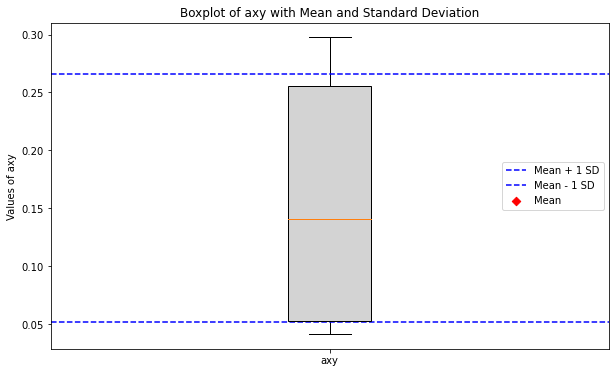

In [29]:
# Calculate mean and standard deviation
mean_axy = results_df1['axy'].mean()
std_axy = results_df1['axy'].std()

# Create a boxplot
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(results_df1['axy'], patch_artist=True)

# Color the box in light grey
for patch in boxplot['boxes']:
    patch.set_facecolor('lightgrey')

# Mark the mean with a red diamond
plt.scatter(1, mean_axy, marker='D', color='red', label='Mean')

# Optionally, you could plot the standard deviation as lines
plt.axhline(y=mean_axy + std_axy, color='blue', linestyle='--', label='Mean + 1 SD')
plt.axhline(y=mean_axy - std_axy, color='blue', linestyle='--', label='Mean - 1 SD')

# Add title and labels
plt.title('Boxplot of axy with Mean and Standard Deviation')
plt.ylabel('Values of axy')
plt.xticks([1], ['axy'])  # Only one box, so we just label the x-axis with 'axy'

# Add legend
plt.legend()

# Show the plot
plt.show()

In [30]:
print(mean_axy)


0.15855906714657778


In [31]:
print(std_axy)

0.10706018054187408
